# Averaging to approximate inner maximization

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,2000)
# seed = 4#62
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

670



# Data preparation

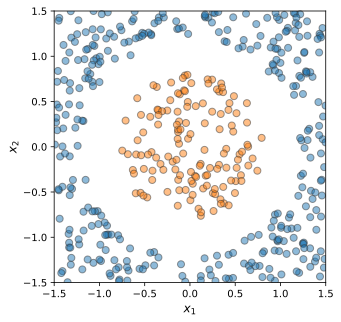

In [2]:
# data_noise = 0.05
factor = 0.2 #buffer zone: Boundary of circle with radius one gets ring of thickness 2*factor
plotlim = [-1.5, 1.5]
subfolder = 'circ_buffer'
data_size = 800
aa_amount = 4
adv_budget = 0.2
batch_size_avg = 64/aa_amount/2



from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('circles_buffer', factor = factor, plotlim = plotlim, random_state = seed, data_size = data_size)


In [3]:

import torch.nn as nn

"""
generates adversarial attacks for prescribed inputs, labels and adversarial budget
attacks have equidistant angle 
returns attacks as tensor of same shape as input in first dimensions but contains additional dimension of dim amount with the attacks
"""
def equi_pert_stack(adv_budget, amount, input, label):
    adv_attacks = torch.zeros_like(input)
    adv_attacks_list = []
    aa_labels_list = []
    
    distance = torch.tensor(2 * np.pi / amount)
    for i in range(amount):
        x1 = torch.sin(i * distance)
        x2 = torch.cos(i * distance)
        pert = adv_budget * torch.tensor([x1, x2])
        print(label.shape)
        
        adv_attacks = input + pert
        adv_attacks_list.append(adv_attacks)
        aa_labels_list.append(label)

    return torch.stack(adv_attacks_list, dim = -1)

"""
generates adversarial attacks for prescribed inputs, labels and adversarial budget
attacks have equidistant angle 
returns attacks with equal labels to input labels in stacked form
"""
def equi_pert_cat(adv_budget, amount, input, label):
    adv_attacks = torch.zeros_like(input)
    adv_attacks_list = []
    aa_labels_list = []
    
    distance = torch.tensor(2 * np.pi / amount)
    for i in range(amount):
        x1 = torch.sin(i * distance)
        x2 = torch.cos(i * distance)
        pert = adv_budget * torch.tensor([x1, x2])
        print(label.shape)
        
        adv_attacks = input + pert
        adv_attacks_list.append(adv_attacks)
        aa_labels_list.append(label)

    return torch.cat(adv_attacks_list, dim = 0), torch.cat(aa_labels_list, dim = 0)



torch.Size([452])
torch.Size([452])
torch.Size([452])
torch.Size([452])
torch.Size([452, 2, 4])


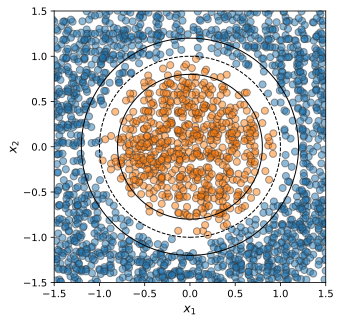

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from torch.utils import data as data
from torch.utils.data import DataLoader, TensorDataset


def create_dataloader_avg(data_type, data_size = 200, noise = 0.15, factor = 0.15, random_state = 1, shuffle = True, plotlim = [-2, 2], label = 'scalar', ticks = True, markersize = 50, aa_amount = 4, batch_size = 64, adv_budget = 0.1, weights = 'true'):
    label_types = ['scalar', 'vector']
    if label not in label_types:
        raise ValueError("Invalid label type. Expected one of: %s" % label_types)
    
    
    if data_type == 'circles':
        X, y = make_circles(data_size, noise=noise, factor=factor, random_state=random_state, shuffle = shuffle)


        
    elif data_type == 'blobs':
        centers = [[-1, -1], [1, 1]]
        X, y = make_blobs(
    n_samples=data_size, centers=centers, cluster_std=noise, random_state=random_state)
        
        
    elif data_type == 'moons':
        X, y = make_moons(data_size, noise = noise, shuffle = shuffle , random_state = random_state)
    
    
    elif data_type == 'xor':
        X = torch.randint(low=0, high=2, size=(data_size, 2), dtype=torch.float32)
        y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).float()
        # y = y.to(torch.int64)
        X += noise * torch.randn(X.shape)
        
    elif data_type == 'circle_buffer':
        X_pre = torch.empty((data_size, 2))

        #uniform distribution on intervall [-2,2] but data is standard transformed later on
        X_pre[:, 0] = torch.rand(data_size) * 3 - 1.5
        X_pre[:, 1] = torch.rand(data_size) * 3 - 1.5

        #exclude data points in buffer zone
        norms = torch.norm(X_pre, dim=1)
        condition = torch.logical_or(
            norms < (1 - factor), norms > (1 + factor))
        X = X_pre[condition, :]

        #asign labels for inner and outer area
        norms = norms[condition]
        y = (norms < (1 - factor)).float()
        
        
    else: 
        print('datatype not supported')
        return None, None
    
    if label == 'vector':
        y = np.array([(2., 0.) if label == 1 else (-2., 0.) for label in y])

    g = torch.Generator()
    g.manual_seed(random_state)
    
    if data_type != 'circle_buffer': #transforming the data set but not the perturbations does not give me a sharp robustness margin
        X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state, shuffle = shuffle)

    X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
    y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

    X_test = torch.Tensor(X_test) # transform to torch tensor for dataloader
    y_test = torch.Tensor(y_test) #transform to torch tensor for dataloader


    if label == 'scalar':
        X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
        y_train = y_train.type(torch.int64) #dtype of original picle.load data

        X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
        y_test = y_test.type(torch.int64) #dtype of original picle.load data
        
    else:
        X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
        y_train = y_train.type(torch.float32) #dtype of original picle.load data

        X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
        y_test = y_test.type(torch.float32) #dtype of original picle.load data

    #add aa_amount of perturbations around each input
    if aa_amount > 0 and weights == 'true':
        aa = equi_pert_stack(adv_budget, aa_amount, X_train, y_train)
        print(aa.shape)
        X_train = X_train.unsqueeze(-1)
        X_train = torch.cat([X_train, aa], dim = 2)
        
    
    elif weights == 'false':
        aa, y_aa = equi_pert_cat(adv_budget, aa_amount, X_train, y_train)
        print(aa.shape)
        X_train = torch.cat([X_train, aa])
        print(X_train.shape)
        y_train = torch.cat([y_train, y_aa])
        


    train_data = TensorDataset(X_train,y_train) # create your datset
    test_data = TensorDataset(X_test, y_test)

    train = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, generator=g)
    test = DataLoader(test_data, batch_size=256, shuffle=shuffle, generator = g) #128 before
    if label == 'scalar':
        data_0 = X_train[y_train == 0]
        data_1 = X_train[y_train == 1]
    else:
        data_0 = X_train[y_train[:,0] > 0]
        data_1 = X_train[y_train[:,0] < 0]
    fig = plt.figure(figsize = (5,5), dpi = 100)
    if weights == 'true':
        plt.scatter(data_0[:, 0, :], data_0[:, 1, :], edgecolor="#333",  alpha = 0.5, s = markersize)
        plt.scatter(data_1[:, 0, :], data_1[:, 1, :], edgecolor="#333", alpha = 0.5, s = markersize)
    elif weights == 'false':
        plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333",  alpha = 0.5, s = markersize)
        plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", alpha = 0.5, s = markersize)
  
        
    if data_type == 'circle_buffer':
        circle_small = plt.Circle((0,0), 1 - factor, fill = False)
        circle_middle = plt.Circle((0,0), 1 , fill = False, linestyle = '--')
        circle_large =  plt.Circle((0,0), 1 + factor, fill = False)
        plt.gca().add_patch(circle_small)
        plt.gca().add_patch(circle_middle)
        plt.gca().add_patch(circle_large)
    plt.xlim(plotlim)
    plt.ylim(plotlim)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel(r'$x_1$', fontsize=12)
    plt.ylabel(r'$x_2$', fontsize=12)
    if ticks == False:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig('trainingset.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
    plt.show()
    
    return train, test


dataloader_avg, dataloader_viz_avg = create_dataloader_avg('circle_buffer', plotlim = plotlim, random_state = seed, data_size = data_size, aa_amount=aa_amount, batch_size=12, adv_budget=adv_budget, factor = factor)

## Model dynamics

In [5]:

"""
Returns points and their norm of gridpoints which are in the circle margin.
"""
def rob_grid(factor, plotlim):
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs_pre = torch.stack([xx1, xx2], dim=-1)
    model_inputs_pre = model_inputs_pre.reshape(-1, 2)

    #exclude data points in buffer zone
    norms = torch.norm(model_inputs_pre, dim=-1)
    condition = torch.logical_and(
        norms > (1 - factor), norms < (1 + factor))  # this changes the shape somehow
    norms = norms[condition]


    return model_inputs_pre[condition, :], norms
    
"""
Computes accuracy in circle robustness margin
"""
def robustness_circ(model, inputs, norms):

    preds, _ = model(inputs)


    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=-1)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)
    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, 0]
    preds = (preds > 0.5).int()

    #all
    correct_outer = torch.logical_and(norms >= 1, preds == 1).int()
    correct_inner = torch.logical_and(norms < 1, preds == 0).int()

    robustness = correct_inner.sum() + correct_outer.sum()
    robustness = robustness / preds.size(0)
    return robustness.item()

In [6]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 10, 10
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity =  'tanh' #'tanh'
architecture = 'inside' #outside


## Training and generating level sets

In [7]:
#was 200 for 500 points
num_epochs = 250 #00 #number of optimization runs in which the dataset is used for gradient decent

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


In [8]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/8
Loss: 1.331
Robust Term Loss: 0.006
Accuracy: 0.391
Epoch 1: 1.333

Iteration 0/8
Loss: 1.160
Robust Term Loss: 0.006
Accuracy: 0.344
Epoch 2: 1.240

Iteration 0/8
Loss: 1.083
Robust Term Loss: 0.006
Accuracy: 0.344
Epoch 3: 1.139

Iteration 0/8
Loss: 0.998
Robust Term Loss: 0.005
Accuracy: 0.391
Epoch 4: 1.036

Iteration 0/8
Loss: 0.972
Robust Term Loss: 0.005
Accuracy: 0.391
Epoch 5: 0.955

Iteration 0/8
Loss: 0.943
Robust Term Loss: 0.005
Accuracy: 0.328
Epoch 6: 0.911

Iteration 0/8
Loss: 0.912
Robust Term Loss: 0.005
Accuracy: 0.344
Epoch 7: 0.854

Iteration 0/8
Loss: 0.791
Robust Term Loss: 0.005
Accuracy: 0.484
Epoch 8: 0.825

Iteration 0/8
Loss: 0.772
Robust Term Loss: 0.004
Accuracy: 0.406
Epoch 9: 0.792

Iteration 0/8
Loss: 0.778
Robust Term Loss: 0.004
Accuracy: 0.344
Epoch 10: 0.751

Iteration 0/8
Loss: 0.729
Robust Term Loss: 0.004
Accuracy: 0.359
Epoch 11: 0.733

Iteration 0/8
Loss: 0.691
Robust Term Loss: 0.004
Accuracy: 0.453
Epoch 12: 0.716

Iteration 0/

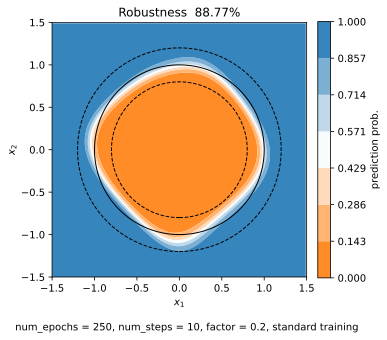

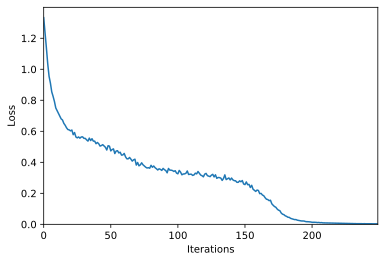

In [9]:
from plots.plots import classification_levelsets
import os
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

footnote = f'{num_epochs = }, {num_steps = }, {factor = }, standard training'
inputs, norms = rob_grid(factor, plotlim)
rob = robustness_circ(anode, inputs, norms)

fig_name_base = os.path.join(subfolder, 'levelsets')
_, ax = classification_levelsets(anode, plotlim = plotlim,
                         footnote=footnote)



def add_circles(ax, factor):
    circle_small = plt.Circle((0,0), 1 - factor, fill = False, linestyle = '--')
    circle_middle = plt.Circle((0,0), 1 , fill = False )
    circle_large = plt.Circle((0,0), 1 + factor, fill = False, linestyle = '--')
    ax.add_patch(circle_small)
    ax.add_patch(circle_middle)
    ax.add_patch(circle_large)
    
add_circles(ax, factor)
plt.title(f'Robustness {rob * 100: .2f}%')
plt.savefig(fig_name_base + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')


plt.show()

plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

torch.Size([464])
torch.Size([464])
torch.Size([464])
torch.Size([464])
torch.Size([1856, 2])
torch.Size([2320, 2])


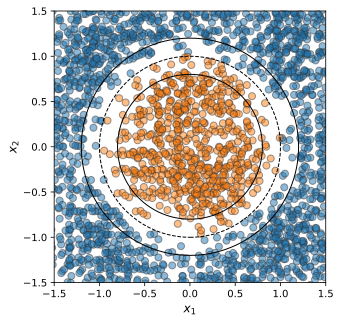


Iteration 0/194
Loss: 1.127
Robust Term Loss: 0.013
Accuracy: 0.500

Iteration 10/194
Loss: 0.908
Robust Term Loss: 0.012
Accuracy: 0.667

Iteration 20/194
Loss: 1.417
Robust Term Loss: 0.016
Accuracy: 0.333

Iteration 30/194
Loss: 0.879
Robust Term Loss: 0.012
Accuracy: 0.500

Iteration 40/194
Loss: 1.059
Robust Term Loss: 0.010
Accuracy: 0.417

Iteration 50/194
Loss: 0.712
Robust Term Loss: 0.006
Accuracy: 0.667

Iteration 60/194
Loss: 1.039
Robust Term Loss: 0.009
Accuracy: 0.333

Iteration 70/194
Loss: 0.785
Robust Term Loss: 0.008
Accuracy: 0.500

Iteration 80/194
Loss: 0.673
Robust Term Loss: 0.006
Accuracy: 0.667

Iteration 90/194
Loss: 0.524
Robust Term Loss: 0.006
Accuracy: 0.833

Iteration 100/194
Loss: 0.704
Robust Term Loss: 0.008
Accuracy: 0.500

Iteration 110/194
Loss: 0.908
Robust Term Loss: 0.008
Accuracy: 0.250

Iteration 120/194
Loss: 0.871
Robust Term Loss: 0.009
Accuracy: 0.250

Iteration 130/194
Loss: 0.744
Robust Term Loss: 0.005
Accuracy: 0.417

Iteration 140/19

In [10]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
dataloader_noweights, dataloader_viz_noweights = create_dataloader_avg(
    'circle_buffer', plotlim=plotlim, random_state=seed, data_size=data_size, aa_amount=aa_amount, batch_size=12, adv_budget=adv_budget, factor=factor, weights = 'false')

rnode_noweights = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode_noweights = torch.optim.Adam(rnode_noweights.parameters(), lr=1e-3) 

trainer_rnode_noweights = doublebackTrainer(rnode_noweights, optimizer_rnode_noweights, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True) 
trainer_rnode_noweights.train(dataloader_noweights, num_epochs)

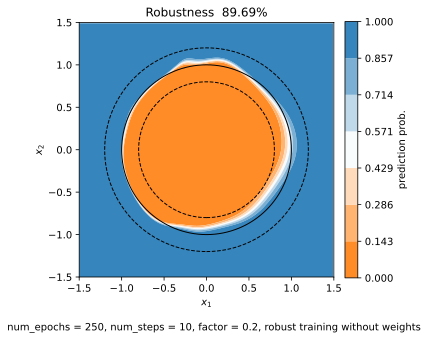

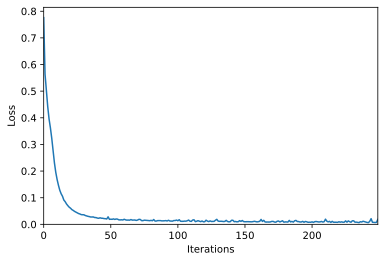

In [11]:
footnote = f'{num_epochs = }, {num_steps = }, {factor = }, robust training without weights'
rob = robustness_circ(rnode_noweights, inputs, norms)

fig_name_base = os.path.join(subfolder, 'levelsets')
_, ax = classification_levelsets(rnode_noweights, plotlim=plotlim,
                                 footnote=footnote)


def add_circles(ax, factor):
    circle_small = plt.Circle((0, 0), 1 - factor, fill=False, linestyle='--')
    circle_middle = plt.Circle((0, 0), 1, fill=False)
    circle_large = plt.Circle((0, 0), 1 + factor, fill=False, linestyle='--')
    ax.add_patch(circle_small)
    ax.add_patch(circle_middle)
    ax.add_patch(circle_large)


add_circles(ax, factor)
plt.title(f'Robustness {rob * 100: .2f}%')
plt.savefig(fig_name_base + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')


plt.show()

plt.plot(trainer_rnode_noweights.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode_noweights.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


## New Trainer

In [12]:
class Trainer_avg():
    """
    Given an optimizer, we write the training loop for minimizing the functional.
    We need several hyperparameters to define the different functionals.

    ***
    -- The boolean "turnpike" indicates whether we integrate the training error over [0,T]
    where T is the time horizon intrinsic to the model.
    -- The boolean "fixed_projector" indicates whether the output layer is given or trained
    -- The float "bound" indicates whether we consider L1+Linfty reg. problem (bound>0.), or 
    L2 reg. problem (bound=0.). If bound>0., then bound represents the upper threshold for the 
    weights+biases.
    ***
    """
    def __init__(self, model, optimizer, device, cross_entropy=True,
                 print_freq=10, record_freq=10, verbose=True, save_dir=None, 
                 turnpike=True, bound=0., fixed_projector=False, softmax_param = 10, rob_grid = None):
        self.model = model
        self.optimizer = optimizer
        self.cross_entropy = cross_entropy
        self.device = device
        self.loss_func = nn.CrossEntropyLoss()
        self.print_freq = print_freq
        self.record_freq = record_freq
        self.steps = 0
        self.save_dir = save_dir
        self.verbose = verbose
        self.turnpike = turnpike
        # In case we consider L1-reg. we threshold the norm. 
        # Examples: M \sim T for toy datasets; 200 for mnist
        self.threshold = bound    
        self.fixed_projector = fixed_projector

        self.histories = {'loss_history': [], 'acc_history': [],
                          'epoch_loss_history': [], 'epoch_acc_history': [], 'epoch_rob_history': []}
        self.buffer = {'loss': [], 'accuracy': []}
        self.is_resnet = hasattr(self.model, 'num_layers')
        self.loss_no_red_fun = nn.CrossEntropyLoss(reduction='none')
        self.softmax_param = softmax_param
        self.rob_grid = rob_grid


    def train(self, data_loader, num_epochs):
        for epoch in range(num_epochs):
            avg_loss = self._train_epoch(data_loader, epoch)
            if self.verbose:
                print("Epoch {}: {:.3f}".format(epoch + 1, avg_loss))

    def _train_epoch(self, data_loader, epoch):
        epoch_loss = 0.
        epoch_acc = 0.
        for i, (x_batch, y_batch) in enumerate(data_loader):
            self.optimizer.zero_grad()
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            #calculate average of eps perturbations
            
            
            ## Empirical loss averaged along equidistant eps perturbations
            loss_pre = torch.zeros_like(x_batch[:, 0, :])
            
            for j in range(x_batch.size(-1)):
                
                y_pred, _ = self.model(x_batch[:, :, j])
                # print('y_pred', y_pred)
                # print('y_batch', y_batch)

                time_steps = self.model.time_steps 
                T = self.model.T
                dt = T/time_steps
                
        
        
                #reduction controls the output, which otherwise sums the batch, or is a weighted average with custom weights. It should be possible to add the gibbs weights directly into the loss function.                
                
                loss_pre[:,j] = self.loss_no_red_fun(y_pred, y_batch)
                
                
                #log accuracy on real data not perturbed data
                if j == 0:
                    m = nn.Softmax() 
                    softpred = m(y_pred)
                    softpred = torch.argmax(softpred, 1)  
                    epoch_acc += (softpred == y_batch).sum().item()/(y_batch.size(0))       
                else:
                    epoch_loss += self.loss_func(y_pred, y_batch).item()
                    
            # print(f'before weights: {loss_pre = }')
                
            
            
            with torch.no_grad():
                weights = torch.empty_like(loss_pre)
                m_aa = nn.Softmax(dim = -1) #average along the attacks according to softmax/gibbs
                
                weights = loss_pre * self.softmax_param 
                weights = m_aa(weights)
            
            loss = torch.sum(loss_pre * weights, dim = -1) #sum everything up to obtain average weighted loss
            loss = loss.mean()
            
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()


        # Record epoch mean information
        self.histories['epoch_loss_history'].append(epoch_loss / len(data_loader))
        if not self.fixed_projector:
            self.histories['epoch_acc_history'].append(epoch_acc / len(data_loader))
            
        if rob_grid is not None:
            test_rob = robustness_circ(self.model, inputs, norms)
            self.histories['epoch_rob_history'].append(test_rob) 
        
        return epoch_loss / len(data_loader)





In [13]:
softmax_param = 1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3)

trainer_rnode = Trainer_avg(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike=turnpike,
                            bound=bound, fixed_projector=fp, verbose=True, softmax_param=softmax_param)
trainer_rnode.train(dataloader_avg, num_epochs)


/var/folders/lk/x8186w8j3_s9plr83dmmwnm00000gn/T/ipykernel_602/60643503.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)


Epoch 1: 5.721
Epoch 2: 4.279
Epoch 3: 3.634
Epoch 4: 3.327
Epoch 5: 3.100
Epoch 6: 2.932
Epoch 7: 2.838
Epoch 8: 2.778
Epoch 9: 2.721
Epoch 10: 2.664
Epoch 11: 2.596
Epoch 12: 2.540
Epoch 13: 2.474
Epoch 14: 2.408
Epoch 15: 2.356
Epoch 16: 2.295
Epoch 17: 2.227
Epoch 18: 2.175
Epoch 19: 2.121
Epoch 20: 2.084
Epoch 21: 2.039
Epoch 22: 2.015
Epoch 23: 1.993
Epoch 24: 1.983
Epoch 25: 1.956
Epoch 26: 1.929
Epoch 27: 1.913
Epoch 28: 1.900
Epoch 29: 1.879
Epoch 30: 1.876
Epoch 31: 1.841
Epoch 32: 1.808
Epoch 33: 1.814
Epoch 34: 1.775
Epoch 35: 1.757
Epoch 36: 1.718
Epoch 37: 1.680
Epoch 38: 1.614
Epoch 39: 1.569
Epoch 40: 1.501
Epoch 41: 1.440
Epoch 42: 1.343
Epoch 43: 1.225
Epoch 44: 1.093
Epoch 45: 0.960
Epoch 46: 0.821
Epoch 47: 0.683
Epoch 48: 0.563
Epoch 49: 0.458
Epoch 50: 0.392
Epoch 51: 0.330
Epoch 52: 0.285
Epoch 53: 0.256
Epoch 54: 0.228
Epoch 55: 0.211
Epoch 56: 0.188
Epoch 57: 0.178
Epoch 58: 0.162
Epoch 59: 0.154
Epoch 60: 0.142
Epoch 61: 0.131
Epoch 62: 0.125
Epoch 63: 0.113
E

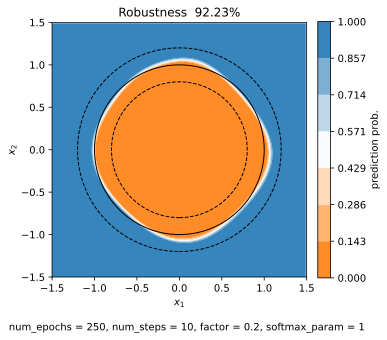

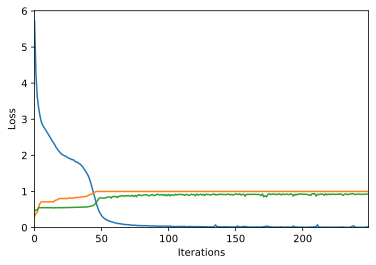

In [14]:
inputs, norms = rob_grid(factor, plotlim)
rob = robustness_circ(rnode, inputs, norms)

footnote = f'{num_epochs = }, {num_steps = }, {factor = }, {softmax_param = }'
fig, ax = classification_levelsets(rnode, plotlim = plotlim, footnote=footnote)
add_circles(ax, factor)
plt.title(f'Robustness {rob * 100: .2f}%')
plt.savefig(fig_name_base + '_rob' + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')


plt.show()

plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.plot(trainer_rnode.histories['epoch_acc_history'])
plt.plot(trainer_rnode.histories['epoch_rob_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()




In [15]:
softmax_param = 10

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode10 = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode10 = torch.optim.Adam(rnode10.parameters(), lr=1e-3)

trainer_rnode10 = Trainer_avg(rnode10, optimizer_rnode10, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, softmax_param=softmax_param) 
trainer_rnode10.train(dataloader_avg, num_epochs)

/var/folders/lk/x8186w8j3_s9plr83dmmwnm00000gn/T/ipykernel_602/60643503.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)


Epoch 1: 5.786
Epoch 2: 4.355
Epoch 3: 3.663
Epoch 4: 3.336
Epoch 5: 3.129
Epoch 6: 2.951
Epoch 7: 2.871
Epoch 8: 2.798
Epoch 9: 2.743
Epoch 10: 2.700
Epoch 11: 2.657
Epoch 12: 2.617
Epoch 13: 2.576
Epoch 14: 2.532
Epoch 15: 2.486
Epoch 16: 2.441
Epoch 17: 2.413
Epoch 18: 2.368
Epoch 19: 2.354
Epoch 20: 2.304
Epoch 21: 2.267
Epoch 22: 2.233
Epoch 23: 2.220
Epoch 24: 2.197
Epoch 25: 2.178
Epoch 26: 2.157
Epoch 27: 2.142
Epoch 28: 2.130
Epoch 29: 2.122
Epoch 30: 2.083
Epoch 31: 2.077
Epoch 32: 2.056
Epoch 33: 2.035
Epoch 34: 2.008
Epoch 35: 1.997
Epoch 36: 1.956
Epoch 37: 1.926
Epoch 38: 1.890
Epoch 39: 1.843
Epoch 40: 1.793
Epoch 41: 1.738
Epoch 42: 1.667
Epoch 43: 1.567
Epoch 44: 1.465
Epoch 45: 1.335
Epoch 46: 1.204
Epoch 47: 1.055
Epoch 48: 0.929
Epoch 49: 0.773
Epoch 50: 0.646
Epoch 51: 0.547
Epoch 52: 0.465
Epoch 53: 0.409
Epoch 54: 0.352
Epoch 55: 0.318
Epoch 56: 0.301
Epoch 57: 0.257
Epoch 58: 0.235
Epoch 59: 0.214
Epoch 60: 0.189
Epoch 61: 0.176
Epoch 62: 0.165
Epoch 63: 0.156
E

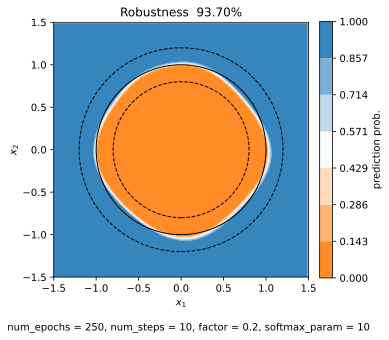

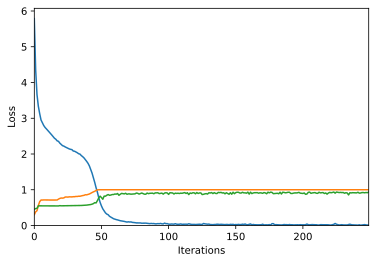

In [16]:
inputs, norms = rob_grid(factor, plotlim)
rob = robustness_circ(rnode10, inputs, norms)

footnote = f'{num_epochs = }, {num_steps = }, {factor = }, {softmax_param = }'
fig, ax = classification_levelsets(rnode10, plotlim = plotlim, footnote = footnote)
add_circles(ax, factor)
plt.title(f'Robustness {rob * 100: .2f}%')
plt.savefig(fig_name_base + '_rob10' + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')
plt.show()

plt.plot(trainer_rnode10.histories['epoch_loss_history'])
plt.plot(trainer_rnode10.histories['epoch_acc_history'])
plt.plot(trainer_rnode10.histories['epoch_rob_history'])
plt.xlim(0, len(trainer_rnode10.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [17]:
softmax_param = 1000

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode_max = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode_max = torch.optim.Adam(rnode_max.parameters(), lr=1e-3)

trainer_rnode_max = Trainer_avg(rnode_max, optimizer_rnode_max, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, softmax_param=softmax_param) 
trainer_rnode_max.train(dataloader_avg, num_epochs)

/var/folders/lk/x8186w8j3_s9plr83dmmwnm00000gn/T/ipykernel_602/60643503.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)


Epoch 1: 5.835
Epoch 2: 4.358
Epoch 3: 3.682
Epoch 4: 3.359
Epoch 5: 3.154
Epoch 6: 2.990
Epoch 7: 2.911
Epoch 8: 2.888
Epoch 9: 2.849
Epoch 10: 2.833
Epoch 11: 2.811
Epoch 12: 2.771
Epoch 13: 2.750
Epoch 14: 2.718
Epoch 15: 2.707
Epoch 16: 2.671
Epoch 17: 2.659
Epoch 18: 2.620
Epoch 19: 2.619
Epoch 20: 2.594
Epoch 21: 2.572
Epoch 22: 2.538
Epoch 23: 2.516
Epoch 24: 2.493
Epoch 25: 2.481
Epoch 26: 2.459
Epoch 27: 2.456
Epoch 28: 2.415
Epoch 29: 2.393
Epoch 30: 2.389
Epoch 31: 2.375
Epoch 32: 2.345
Epoch 33: 2.314
Epoch 34: 2.308
Epoch 35: 2.284
Epoch 36: 2.259
Epoch 37: 2.242
Epoch 38: 2.220
Epoch 39: 2.236
Epoch 40: 2.203
Epoch 41: 2.166
Epoch 42: 2.155
Epoch 43: 2.137
Epoch 44: 2.107
Epoch 45: 2.077
Epoch 46: 2.037
Epoch 47: 2.039
Epoch 48: 1.975
Epoch 49: 1.930
Epoch 50: 1.887
Epoch 51: 1.836
Epoch 52: 1.793
Epoch 53: 1.721
Epoch 54: 1.650
Epoch 55: 1.562
Epoch 56: 1.507
Epoch 57: 1.420
Epoch 58: 1.324
Epoch 59: 1.255
Epoch 60: 1.138
Epoch 61: 1.047
Epoch 62: 0.928
Epoch 63: 0.836
E

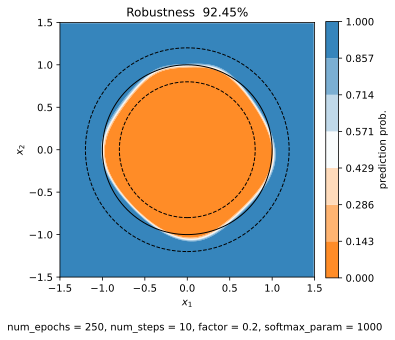

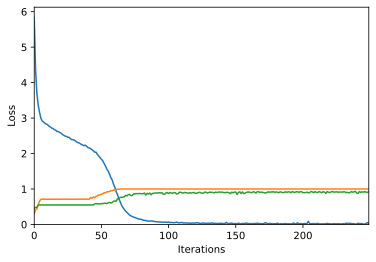

In [18]:
inputs, norms = rob_grid(factor, plotlim)
rob = robustness_circ(rnode_max, inputs, norms)

footnote = f'{num_epochs = }, {num_steps = }, {factor = }, {softmax_param = }'
fig, ax = classification_levelsets(rnode_max, plotlim = plotlim, footnote = footnote)
add_circles(ax, factor)
plt.title(f'Robustness {rob * 100: .2f}%')
plt.savefig(fig_name_base + '_rob_max' + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')
plt.show()

plt.plot(trainer_rnode_max.histories['epoch_loss_history'])
plt.plot(trainer_rnode_max.histories['epoch_acc_history'])
plt.plot(trainer_rnode_max.histories['epoch_rob_history'])
plt.xlim(0, len(trainer_rnode_max.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

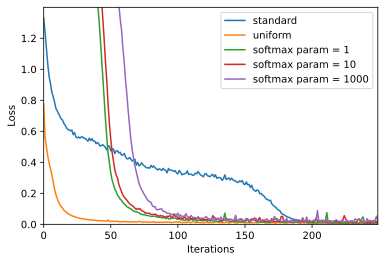

In [19]:
plt.plot(trainer_anode.histories['epoch_loss_history'], label = 'standard')
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(trainer_rnode_noweights.histories['epoch_loss_history'], label = 'uniform')
plt.plot(trainer_rnode.histories['epoch_loss_history'], label=f'softmax param = {trainer_rnode.softmax_param}')
plt.plot(trainer_rnode10.histories['epoch_loss_history'], label=f'softmax param = {trainer_rnode10.softmax_param}')
plt.plot(trainer_rnode_max.histories['epoch_loss_history'], label=f'softmax param = {trainer_rnode_max.softmax_param}')
plt.legend()
plt.show()

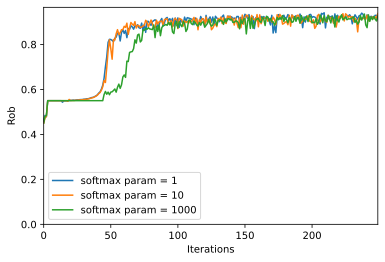

In [20]:
plt.plot(trainer_rnode.histories['epoch_rob_history'], label=f'softmax param = {trainer_rnode.softmax_param}')
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Rob')
plt.plot(trainer_rnode10.histories['epoch_rob_history'], label=f'softmax param = {trainer_rnode10.softmax_param}')
plt.plot(trainer_rnode_max.histories['epoch_rob_history'], label=f'softmax param = {trainer_rnode_max.softmax_param}')
plt.legend()
plt.show()

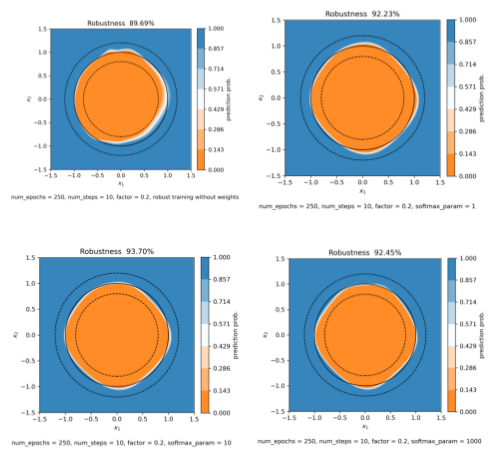

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the PNG images
img1 = mpimg.imread(fig_name_base + '.png')
img2 = mpimg.imread(fig_name_base + '_rob.png')
img3 = mpimg.imread(fig_name_base + '_rob10.png')
img4 = mpimg.imread(fig_name_base + '_rob_max.png')

# Create a 1x3 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(7, 7))  # Adjust the figsize as needed

# Display each image in its respective subplot
axes[0,0].imshow(img1)
axes[0,0].axis('off')  # To turn off the axis numbers and ticks

axes[0,1].imshow(img2)
axes[0,1].axis('off')

axes[1,0].imshow(img3)
axes[1,0].axis('off')

axes[1,1].imshow(img4)
axes[1,1].axis('off')

plt.tight_layout()
plt.savefig(fig_name_base + 'comp' + str(seed) + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')
plt.show()


# after comparison plot

I want to visualize the separation boundary in the final linear layer.